This notebook aims at exploring data for symbol 1 (asset with symbol_id = 1) and build a dataset for further research.

In [1]:
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader, clean_na_values, select_symbol_id
from config import USER
import polars as pl
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [2]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEYS_S3s = [f"train.parquet/partition_id={i}/part-0.parquet" for i in range(10)]

data = pl.concat([reader.read_parquet(FILE_KEY_S3) for FILE_KEY_S3 in tqdm(FILE_KEYS_S3s)])
data.head()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:35<00:00,  9.57s/it]


shape: (5, 92)
┌─────────┬─────────┬───────────┬──────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ weight   ┆ … ┆ responder_ ┆ responder_ ┆ responder_ ┆ responder_ │
│ ---     ┆ ---     ┆ ---       ┆ ---      ┆   ┆ 5          ┆ 6          ┆ 7          ┆ 8          │
│ i16     ┆ i16     ┆ i8        ┆ f32      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│         ┆         ┆           ┆          ┆   ┆ f32        ┆ f32        ┆ f32        ┆ f32        │
╞═════════╪═════════╪═══════════╪══════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 0       ┆ 1         ┆ 3.889038 ┆ … ┆ 1.218368   ┆ 0.775981   ┆ 0.346999   ┆ 0.095504   │
│ 0       ┆ 0       ┆ 7         ┆ 1.370613 ┆ … ┆ 5.0        ┆ 0.703665   ┆ 0.216683   ┆ 0.778639   │
│ 0       ┆ 0       ┆ 9         ┆ 2.285698 ┆ … ┆ 0.099793   ┆ 2.109352   ┆ 0.670881   ┆ 0.772828   │
│ 0       ┆ 0       ┆ 10        ┆ 0.690606 ┆ … ┆ 1.225376   ┆ 1.114137   ┆ 0.775199   ┆ -1.379516  │
│ 0       ┆ 0       ┆ 14        ┆ 0.44057  ┆ … ┆ -5.0       ┆ -3.57282   ┆ -1.089123  ┆ -5.0       │
└─────────┴─────────┴───────────┴──────────┴───┴────────────┴────────────┴────────────┴────────────┘

# Processing

In [3]:
# select data with symbol_id = 1 and drop columns with 10% or more nans
data_clean_symb_1 = clean_na_values(select_symbol_id(data, id = 1), threshold = 0.1)

# add lagged targets as feature 
data_clean_symb_1 = data_clean_symb_1.with_columns([
    pl.col(col).shift(1).alias(f"feature_{col}_lagged")
    for col in data.columns if "responder" in col
])
data_clean_symb_1 = data_clean_symb_1.select(sorted(data_clean_symb_1.columns))

## Visualization

Let's visualize each time serie, we also plot the differentiated time series.

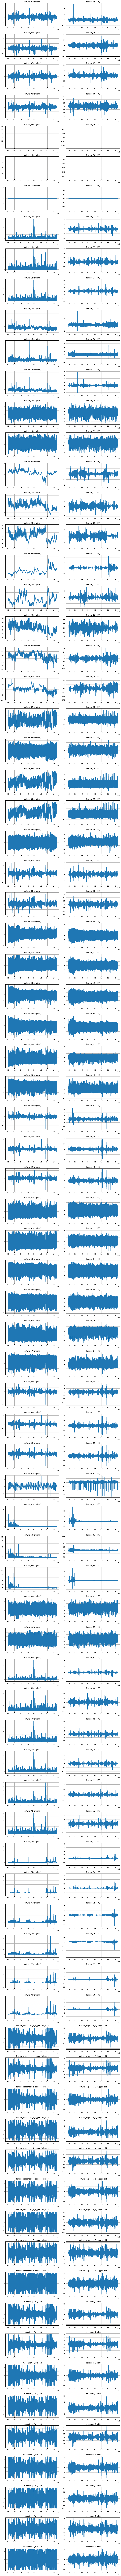

In [4]:
to_plot = data_clean_symb_1[[col for col in data_clean_symb_1.columns if "feature" in col or "responder" in col]]

pdf = to_plot.to_pandas()
n_cols = pdf.shape[1]

fig, axes = plt.subplots(n_cols, 2, figsize=(12, 3*n_cols), sharex=False)

if n_cols == 1:
    axes = np.array([axes])

for i, col in enumerate(pdf.columns):
    series = pdf[col].values
    diff = np.diff(series)

    axes[i, 0].plot(series)
    axes[i, 0].set_title(f"{col} (original)")
    axes[i, 0].grid(True)

    axes[i, 1].plot(diff)
    axes[i, 1].set_title(f"{col} (diff)")
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()


Differentiated time series looks more stationary. Hence we replace each feature time serie with the differentiated time serie.

In [5]:
data_clean_symb_1 = data_clean_symb_1.with_columns([
    pl.col(col).diff()
    for col in data_clean_symb_1.columns if "feature" in col and "lagged" not in col
])

# remove features 9, 10 and 11 because they are constant
data_clean_symb_1 = data_clean_symb_1.drop(["feature_09", "feature_10", "feature_11"])

data_clean_symb_1 = data_clean_symb_1.drop_nulls()

# save dataset
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"
reader.save_parquet(data_clean_symb_1, FILE_KEY_S3)